# Статистический анализ данных, проектная работа. 
# Определение перспективного тарифа для телеком-компании

## Описание проекта
В нашем распоряжении данные 500 пользователей «Мегалайна»(федерального оператора сотовой связи): кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра».
Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов

Тариф «Смарт»:

Ежемесячная плата: 550 рублей.
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика.
Стоимость услуг сверх тарифного пакета:
Минута разговора: 3 рубля.
Сообщение: 3 рубля.
1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»:

Ежемесячная плата: 1950 рублей.
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика.
Стоимость услуг сверх тарифного пакета:
Минута разговора: 1 рубль.
Сообщение: 1 рубль.
1 Гб интернет-трафика: 150 рублей.

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Шаг 1 . Откроем файлы с данными и изучим общую информацию.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy import stats as st
import math

users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=[0])
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [2]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В таблице представлена информация о пользователях, 8 колонок, 500 строк:
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

Имеются пропуски в столбце churn_date, они значат, что пользователи всё еще пользуются тарифом, нужно изменитть тип даннных.

In [4]:
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В таблице представлена информация о звонках, 202607 строки, 4 колонки:
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

Пропусков нет, но нужно изменить тип данных.


In [6]:
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [7]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В таблице представлена информация о сообщениях, 123036 строк и 3 колонки:
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

Пропусков нет, но нужно изменить тип данных. 

In [8]:
internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


В таблице представлена информация об интернет-сессиях, 149396 строки, 4 колонки:
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

Пропусков нет, но нужно изменить тип данных.




In [10]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В таблице представлена информация о тарифах, две строки, 8 колонок:
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Пропусков нет, но нужно изменить тип данных.




### Вывод: 
Отличный набор данных, нет потеряных данных и аномальных значений, нужно лишь проверить на дубликаты и заменить типы данных, где это необходимо.

## Шаг 2. Предобработка данных

Удалим явные дубликаты во всех таблицах, заменим типы данных и произведем округления согласно политике «Мегалайн»

In [12]:
users.duplicated().sum()

0

In [13]:
calls.duplicated().sum()

0

In [14]:
messages.duplicated().sum()

0

In [15]:
internet.duplicated().sum()

0

А дубликатов и нет

In [16]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Неявных дубликатов в названиях тарифов тоже нет, пользователей с тарифом ultra более, чем вдвое меньше, чем пользователей с тарифом smart

Заменим типы данных и округлим длительность звонков и количество потребленного трафика в большую сторону

In [17]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

calls['id'] = calls['id'].astype(int)
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)
calls['user_id'] = calls['user_id'].astype(int)
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

messages['id'] = messages['id'].astype(int)
messages['user_id'] = messages['user_id'].astype(int)
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

internet['id'] = internet['id'].astype(int)
internet['user_id'] = internet['user_id'].astype(int)
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype(int)
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')


### Вывод:

Убедились, что нет дубликатов, заменили ошибочные типы данных на верные и округлили значения.

## Шаг 3. Подготовим данные, проведем необходимые рассчёты.

Изучим длительность звонков и количество интернет-траффика, посмотрим, как выглядят данные в диаграммах.

In [18]:
calls.describe()

,id,duration,user_id
count,2.026070e+05,202607.000000,202607.000000
mean,1.212254e+06,7.158198,1253.940619
std,1.725756e+06,5.959173,144.722751
min,1.000000e+04,0.000000,1000.000000
25%,1.012286e+06,2.000000,1126.000000
50%,1.179376e+06,6.000000,1260.000000
75%,1.358126e+06,11.000000,1379.000000
max,1.458115e+07,38.000000,1499.000000


<AxesSubplot:ylabel='Frequency'>

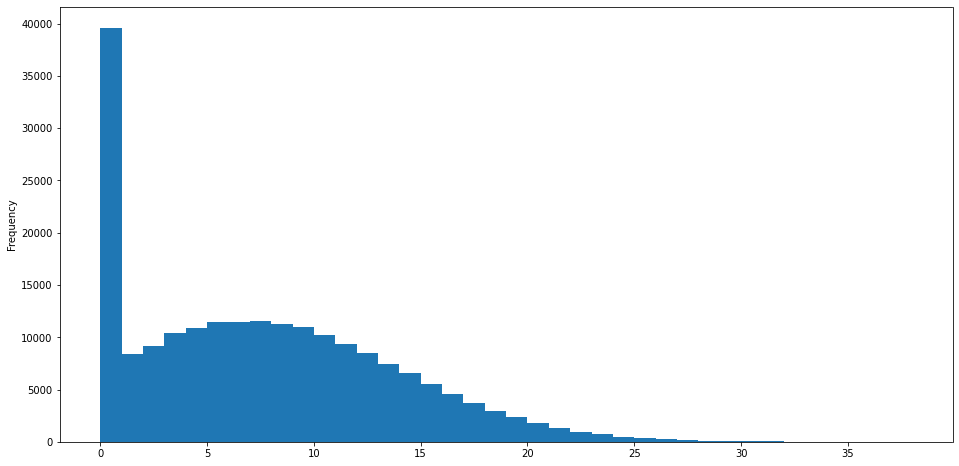

In [19]:
calls['duration'].plot(kind='hist', bins = 38, figsize=(16, 8))

Видим, что много звонков длятся 0 минут, похоже, что это пропущенные вызовы. Так как минуты не расходуются, то и абонент за эти звонки  не платит, можно их смело удалить, для анализа они нам не понадобятся.

In [20]:
calls = calls.query('duration != 0')

In [21]:
internet.describe()

,id,mb_used,user_id
count,1.493960e+05,149396.000000,149396.000000
mean,8.968475e+05,370.622098,1252.099842
std,5.419758e+05,278.387019,144.050823
min,1.000000e+04,0.000000,1000.000000
25%,1.389878e+05,139.000000,1130.000000
50%,1.145212e+06,349.000000,1251.000000
75%,1.321559e+06,560.000000,1380.000000
max,1.499156e+06,1725.000000,1499.000000


<AxesSubplot:ylabel='Frequency'>

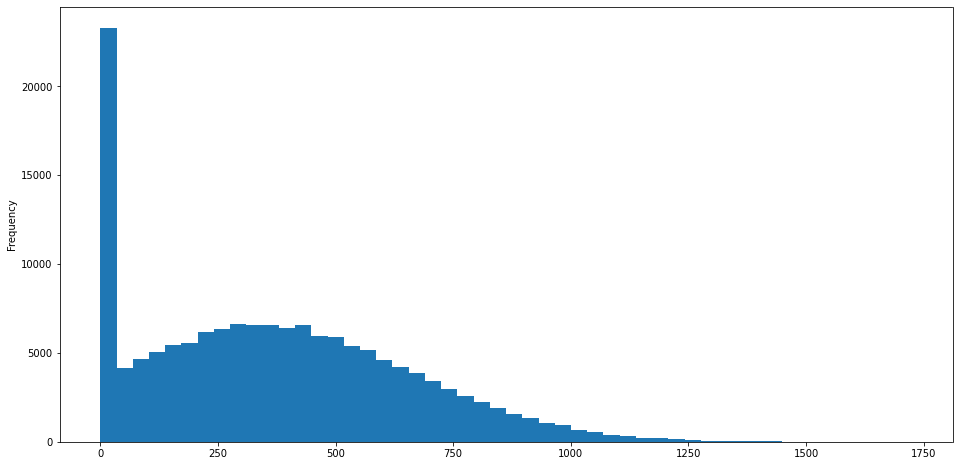

In [22]:
internet['mb_used'].plot(kind='hist', bins = 50, figsize=(16, 8))

Здесь тоже видим много нулевых значений. Видимо, это факты установки соединения без расхода траффика, нет трафика - нет платы, эти данные также удалим.

In [23]:
internet = internet.query('mb_used != 0')

Посчитаем количество израсходованных минут, смс, интернет трафика и выручки с каждого пользователя по месяцам

Добавим колонку с месяцами

In [24]:
def month(df, col): 
    df = df.assign(month=df[col].dt.month)
    return df

Посчитаем количество звонков и минут, создадим таблицу по пользователям, количеству звонков и израсходованных минут по месяцам.

In [25]:
calls = month(calls, 'call_date')

In [26]:
calls_pivot = calls.pivot_table(index=['user_id', 'month'],
                                values='duration', aggfunc=("sum",'count')).reset_index()

calls_pivot.columns = ('user_id', 'month', 'calls_count', 'mins')
calls_pivot

,user_id,month,calls_count,mins
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466
...,...,...,...,...
3163,1498,10,30,247
3164,1499,9,8,70
3165,1499,10,44,449
3166,1499,11,62,612


Посчитаем количество отправленных смс, создадим таблицу по пользователям и количеству сообщений по месяцам

In [27]:
messages = month(messages, 'message_date')

In [28]:
messages_pivot = messages.pivot_table(index=['user_id','month'],
                                      values='message_date', aggfunc=('count')).reset_index()

messages_pivot.columns = ('user_id', 'month', 'messages_count')
messages_pivot

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


Посчитаем количество израсходованного трафика, создадим таблицу по пользователям и количеству израсходованных мегабайт по месяцам

In [29]:
internet = month(internet, 'session_date')

In [30]:
internet_pivot = internet.pivot_table(index=['user_id','month'],
                                      values='mb_used', aggfunc=('sum')).reset_index()

internet_pivot.head()

,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581


Посчитаем выручку.

In [31]:
tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff']

Объединим таблицы и посмотрим общую информацию.

In [32]:
data_merge = calls_pivot.merge(messages_pivot, on=('user_id', 'month'), how='outer')
data_merge = data_merge.merge(internet_pivot, on=('user_id', 'month'), how='outer')
data_merge = data_merge.merge(users, on=('user_id'), how='left')
data_merge = data_merge.merge(tariffs, on=('tariff'), how='left')
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   calls_count            3168 non-null   float64       
 3   mins                   3168 non-null   float64       
 4   messages_count         2717 non-null   float64       
 5   mb_used                3201 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   object        
 13  mes

Получили пропуски, они появились, потому что не все абоненты пользовались всеми услугами каждый месяц. Заполним пропуски нулями и заменим тип данных. 

In [33]:
for col in ['calls_count', 'mins', 'messages_count','mb_used']:
    data_merge[col] = data_merge[col].fillna(0).astype(int)

Рассчитаем прибыль компании.

In [34]:
def profit_calculation(df):
    df['profit'] = df['rub_monthly_fee']
    if df['mins'] > df['minutes_included']:
        df['profit'] += (df['mins'] - df['minutes_included']) * df['rub_per_minute']
    if df['messages_count'] > df['messages_included']:
        df['profit'] += (df['messages_count'] - df['messages_included']) * df['rub_per_message']
    if df['mb_used'] > df['mb_per_month_included']:
        df['profit'] += math.ceil((df['mb_used'] - df['mb_per_month_included']) / 1024) * (df['rub_per_gb'])    
    return df

In [35]:
data_merge = data_merge.apply(profit_calculation, axis=1)
data_merge['profit'] = data_merge['profit'].astype(int)
data_merge

,user_id,month,calls_count,mins,messages_count,mb_used,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,5,17,159,22,2256,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
1,1000,6,28,172,60,23257,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
2,1000,7,41,340,75,14016,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
3,1000,8,42,408,81,14070,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
4,1000,9,46,466,57,14581,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,10,0,0,21,19588,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,1550
3210,1489,11,0,0,20,17516,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,1150
3211,1489,12,0,0,35,17341,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,950
3212,1240,2,0,0,0,961,30,NaT,Воронеж,Зинаида,...,2018-02-27,ultra,1000,30720,3000,1950,150,1,1,1950


Удалим колонки, которые нам не нужны.

In [36]:
data_merge = data_merge.drop(['first_name', 'last_name', 'messages_included', 'mb_per_month_included','minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute'], axis=1)
data_merge.columns

Index(['user_id', 'month', 'calls_count', 'mins', 'messages_count', 'mb_used',
       'age', 'churn_date', 'city', 'reg_date', 'tariff', 'profit'],
      dtype='object')

### Вывод: 

Посчитали количество израсходованных минут, смс, интернет трафика и выручки с каждого пользователя по месяцам, выручку и прибыль компании. Очистили данные от ненужных значений.

## Шаг 4 Проведём анализ данных

Посчитаем среднее количество, дисперсию и стандартное отклонение для тарифов

In [37]:
def func_pivot(value):
    table = data_merge.pivot_table(index=('tariff'), values=value,\
                       aggfunc=('median','mean','var','std')).astype(int).reset_index()
    return table

In [38]:
mins_pivot = func_pivot('mins')
mins_pivot

,tariff,mean,median,std,var
0,smart,417,422,190,36219
1,ultra,526,518,317,100873


In [39]:
messages_pivot = func_pivot('messages_count')
messages_pivot

,tariff,mean,median,std,var
0,smart,33,28,28,796
1,ultra,49,38,47,2285


In [40]:
internet_pivot = func_pivot('mb_used')
internet_pivot

,tariff,mean,median,std,var
0,smart,16229,16531,5877,34545911
1,ultra,19486,19324,10096,101935621


Построим гистограммы

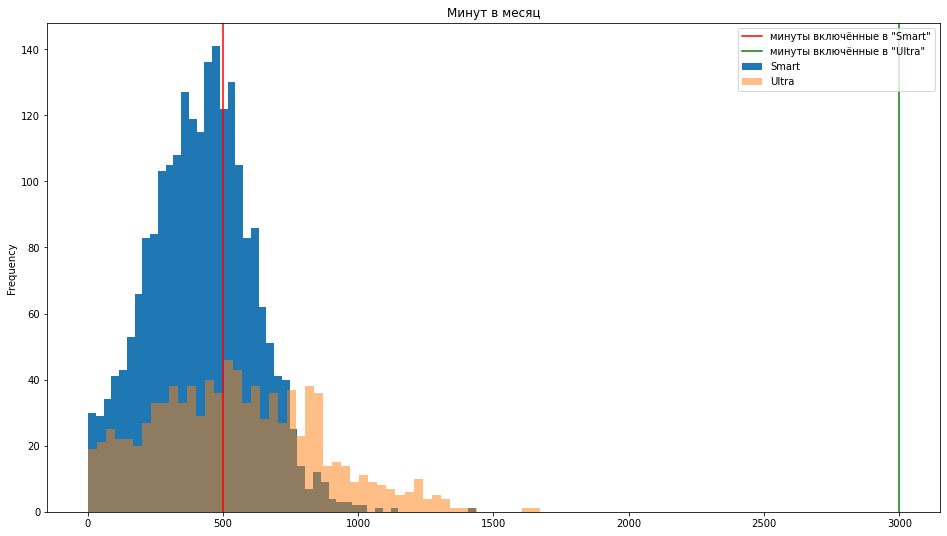

In [41]:
data_merge[(data_merge['tariff'] == 'smart')
           & (data_merge['mins'] !=0)]['mins'].plot(kind='hist', bins=50, title='Минут в месяц', figsize=(16, 9))

data_merge[(data_merge['tariff'] == 'ultra')
           & (data_merge['mins'] !=0)]['mins'].plot(kind='hist', bins=50, alpha = 0.5)

plt.axvline(x=500, color='r')
plt.axvline(x=3000, color='g')
plt.legend(['минуты включённые в "Smart"', 'минуты включённые в "Ultra"', "Smart", "Ultra"], loc=1)

Наблюдаем нормальное распределение. Пользователи тарифа "Smart" часто выходят за пределы включенных в тариф минут. А пользователи тарифа "Ultra" даже не приближаются к пороговому значению.

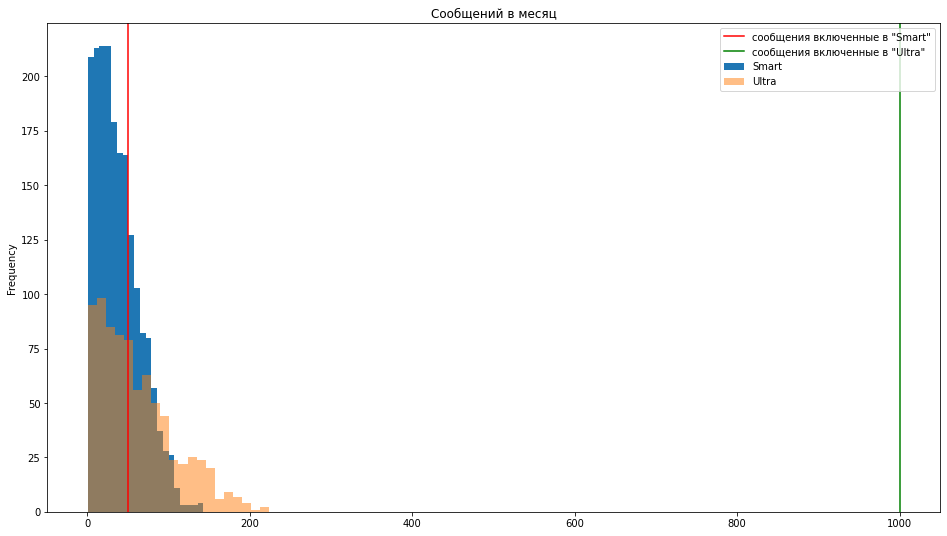

In [42]:
data_merge[(data_merge['tariff'] == 'smart')
           & (data_merge['messages_count'] !=0)]['messages_count'].plot(
    kind='hist', bins=20, title='Сообщений в месяц', figsize=(16, 9))

data_merge[(data_merge['tariff'] == 'ultra')
           & (data_merge['messages_count'] !=0)]['messages_count'].plot(
    kind='hist', bins=20, alpha = 0.5)

plt.axvline(x=50, color='r')
plt.axvline(x=1000, color='g')
plt.legend(['сообщения включенные в "Smart"', 'сообщения включенные в "Ultra"', "Smart", "Ultra"], loc=1)

 И в сообщениях пользователи тарифа "Smart" часто выходят за включенный в тариф лимит, а пользователи тарифа "Ultra" так же как и со звонками далеки от лимита.

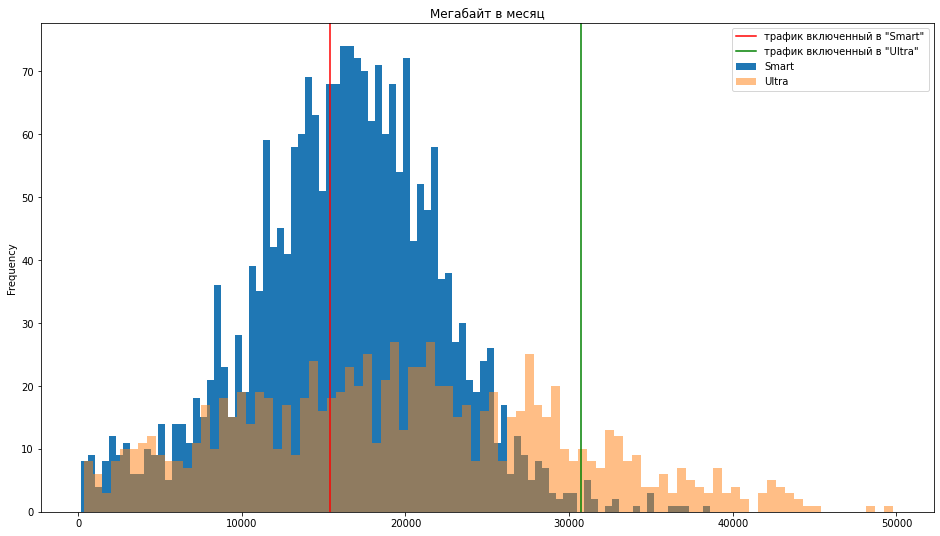

In [43]:
data_merge[(data_merge['tariff'] == 'smart')
           &(data_merge['mb_used'] !=0)]['mb_used'].plot(kind='hist', bins=90, title='Мегабайт в месяц', figsize=(16, 9))

data_merge[(data_merge['tariff'] == 'ultra')
           &(data_merge['mb_used'] !=0)]['mb_used'].plot(kind='hist', bins=90, alpha = 0.5)

plt.axvline(x=15360, color='r')
plt.axvline(x=30720, color='g')
plt.legend(['трафик включенный в "Smart"', 'трафик включенный в "Ultra"', "Smart", "Ultra"], loc=1)

На графике распределение Гаусса. Интернетом абоненты пользуются гораздо активнее чем прочими услугами связи. В среднем пользователи тарифа "Smart" используют 16229 мб. данных в месяц, при лимите 15360 мб.

### Вывод: 

Пользователи тарифа "Smart" используют минуты смс и траффик сверхтарифа, а пользователи тарифа "Ultra" даже не доходят до порога лимита

## Шаг 5. Проверим гипотезы

### Cредняя выручка от пользователей тарифов "Ultra" и "Smart" различается

* H₀: Средняя выручка от пользователей тарифов "Ultra" и "Smart" не различается
* H₁: Средняя выручка от пользователей тарифов "Ultra" и "Smart" различается

In [44]:
df_smart = data_merge[data_merge['tariff'] == 'smart']
df_ultra = data_merge[data_merge['tariff'] == 'ultra']
alpha = 0.05

result = st.ttest_ind(df_smart['profit'], df_ultra['profit'])

print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.9776448000521676e-158
Отвергаем нулевую гипотезу


In [50]:
df_smart['profit'].mean()

1294.6393001345896

In [51]:
df_ultra['profit'].mean()

2071.0659898477156

Нулевая гипотеза не подтвердилась, а значит с большой вероятностью мы можем утверждать, что пользователи тарифов приносят разное количество денег компании.

### Cредняя выручка от пользователей из Москвы отличается от выручки от пользователей из других регионов

* H₀: Средняя выручка от пользователей из Москвы не отличается от выручки от пользователей из других регионов
* H₁: Средняя выручка от пользователей из Москвы отличается от выручки от пользователей из других регионов

In [46]:
df_moscow = data_merge[data_merge['city'] == 'Москва']
df_another_city = data_merge[data_merge['city'] != 'Москва']

abs(np.mean(df_moscow ['profit']) - np.mean(df_another_city['profit'])) / (np.var(df_another_city['profit']))

3.4254083833916284e-05

Сравниваем дисперсии критерием фишера, разница незначительна

In [47]:
alpha = 0.05

result = st.ttest_ind(df_moscow ['profit'], df_another_city['profit'])

print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.531666503831252
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза не отвергнута, большая вероятность того, что пользователи из Москвы тратят столько же сколько пользователи из других городов.

### Вывод: 

Cредняя выручка от пользователей тарифов "Ultra" и "Smart" действительно различается, а вот разницы между выручкой от Москвы и от регионов нет.

## Шаг 6. Общий вывод.

* Мы изучили наши таблицы, проверили их на наличие пустых значений, дубликатов и неправильных типов данных. Затем поменяли типы данных  так как многие были указаны неверно,и подготовили все таблицы для дальнейшего анализа.

* Посчитали сколько минут разговора, сколько сообщений и какой объем интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитали среднее количество, дисперсию и стандартное отклонение.

* Проверили гипотезы. Убедились, что выручка тарифов Смарт и Ультра различается. Убедились, что выручка от клиентов из Москвы и других регионов не отличается.

* Изучив данные, мы выявили, что клиенты тарифа Ультра расходуют больше интернет-трафика, делают больше звонков и отправляют больше сообщений, нежели клиенты тарифа Смарт и практически не превышают лимит своего пакета, чего не скажешь о клиентах тарифа Смарт. Но по годовой выручке, компания получает больше выручки по тарифу Смарт, так как пользователей данного тарифа более, чем в два раза больше чем Ультра. Если считать по каждому пользователю, то в среднем пользователь тарифа Ультра приносит больше выручки в год, чем пользователь Смарта.

* Если считать по итоговой прибыли от тарифов Ультра и Смарт, то Смарт выгоден для компании аж на 700к рублей в год, но если считать ценность пользователя каждого тарифа, то пользователь тарифа Ультра приносит больше дохода, чем пользователь тарифа Смарт.